In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import os
import tabulate
from sklearn.preprocessing import LabelEncoder
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
get_ipython().magic('matplotlib inline')
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('xtick', labelsize=8) 

In [2]:
startTime = datetime.now()
folderPath = "C:/Users/sulayako/datamodels/Airline-delay-prediction-in-Python-master/data"
os.chdir(folderPath)
fdata_list = []

for filename in os.listdir(os.getcwd()):
    if filename.endswith('.csv') and "On_Time_On_Time_Performance_2017_1.csv" in filename:
        temp = pd.read_csv(filename)
        fdata_list.append(temp)

# Concatenate all DataFrames in the list
fdata = pd.concat(fdata_list, ignore_index=True)

In [3]:
folderPath = "C:/Users/sulayako/datamodels/Airline-delay-prediction-in-Python-master/data"
os.chdir(folderPath)
fileName = "On_Time_On_Time_Performance_2017_1.csv"
fdata = pd.read_csv(fileName)
fdata.shape

(450017, 110)

Data Wrangling

In [4]:
#Handles class imbalance through sampling
classDistribution = fdata['ArrDel15'].value_counts()
print('Class imbalance:')
print(classDistribution)
zero = fdata[fdata['ArrDel15']==0].tail(classDistribution.min())
one = fdata[fdata['ArrDel15']==1]
data = pd.concat([zero, one])  

del zero, one

# Combine and sort the DataFrame
data.sort_values(['Year', 'Month', 'DayofMonth', 'DayOfWeek'], ascending=[False, False, False, False], inplace=True)

# Print balanced class distribution
print('Class imbalance evened out:')
print(data['ArrDel15'].value_counts())

# Print number of columns
print(len(data.columns))
len(data.columns)


Class imbalance:
ArrDel15
0.0    341946
1.0     97699
Name: count, dtype: int64
Class imbalance evened out:
ArrDel15
0.0    97699
1.0    97699
Name: count, dtype: int64
110


110

In [5]:
data.head(2)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
325049,2017,1,1,31,2,2017-01-31,WN,19393,WN,N246LV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325050,2017,1,1,31,2,2017-01-31,WN,19393,WN,N8644C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.tail(2)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
425230,2017,1,1,1,7,2017-01-01,VX,21171,VX,N629VA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425236,2017,1,1,1,7,2017-01-01,VX,21171,VX,N633VA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Removing sparse columns
data = data.iloc[:,0:56]
print('Dimension reduced to:')
len(data.columns)

Dimension reduced to:


56

In [8]:
print('Dimension reduced to:')
print(len(data.columns))
print('Sparsity per variable:')
((len(data.index) - data.count())/len(data.index))#Sparsity per variable retained

Dimension reduced to:
56
Sparsity per variable:


Year                    0.0
Quarter                 0.0
Month                   0.0
DayofMonth              0.0
DayOfWeek               0.0
FlightDate              0.0
UniqueCarrier           0.0
AirlineID               0.0
Carrier                 0.0
TailNum                 0.0
FlightNum               0.0
OriginAirportID         0.0
OriginAirportSeqID      0.0
OriginCityMarketID      0.0
Origin                  0.0
OriginCityName          0.0
OriginState             0.0
OriginStateFips         0.0
OriginStateName         0.0
OriginWac               0.0
DestAirportID           0.0
DestAirportSeqID        0.0
DestCityMarketID        0.0
Dest                    0.0
DestCityName            0.0
DestState               0.0
DestStateFips           0.0
DestStateName           0.0
DestWac                 0.0
CRSDepTime              0.0
DepTime                 0.0
DepDelay                0.0
DepDelayMinutes         0.0
DepDel15                0.0
DepartureDelayGroups    0.0
DepTimeBlk          

In [9]:
data.drop(['DepDelay','DepDel15','ArrDelay','DepDelayMinutes','ArrDelayMinutes'],
          axis=1, inplace=True)#To be excluded as per the task
data.drop(['CancellationCode'], axis=1, inplace=True)#Removed due to 100% sparsity as seen in above cell
data["FlightDate"] = data["FlightDate"].apply(lambda x: int(''.join(x.split("-"))))#Formatting date for convinience

In [10]:
print('Datatype of variables:')
data.dtypes

Datatype of variables:


Year                      int64
Quarter                   int64
Month                     int64
DayofMonth                int64
DayOfWeek                 int64
FlightDate                int64
UniqueCarrier            object
AirlineID                 int64
Carrier                  object
TailNum                  object
FlightNum                 int64
OriginAirportID           int64
OriginAirportSeqID        int64
OriginCityMarketID        int64
Origin                   object
OriginCityName           object
OriginState              object
OriginStateFips           int64
OriginStateName          object
OriginWac                 int64
DestAirportID             int64
DestAirportSeqID          int64
DestCityMarketID          int64
Dest                     object
DestCityName             object
DestState                object
DestStateFips             int64
DestStateName            object
DestWac                   int64
CRSDepTime                int64
DepTime                 float64
Departur

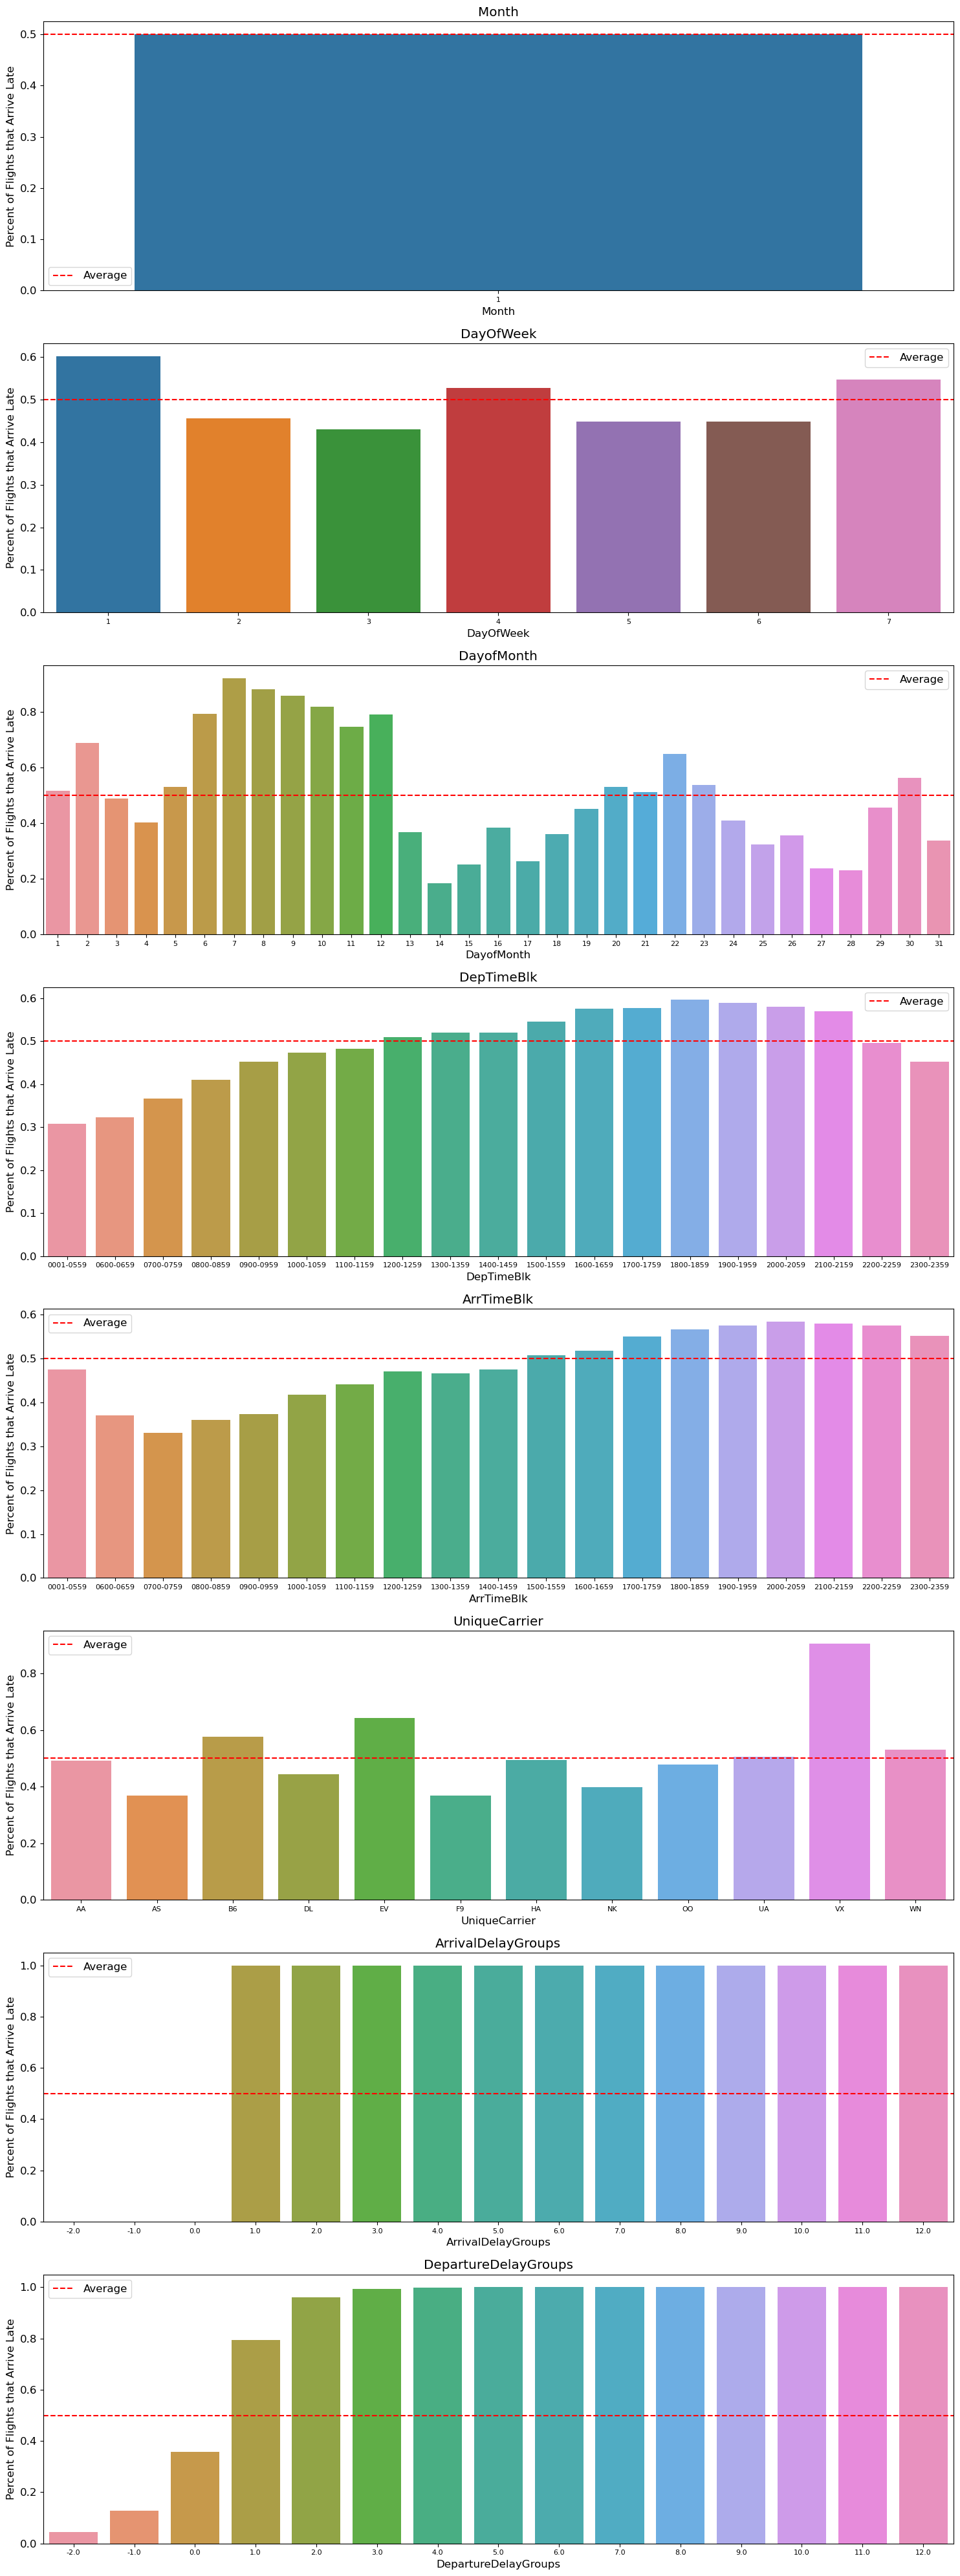

In [11]:
# Define attributes for analysis
avgLate = data['ArrDel15'].mean()
attributes = ['Month', 'DayOfWeek', 'DayofMonth', 'DepTimeBlk', 'ArrTimeBlk', 'UniqueCarrier',
               'ArrivalDelayGroups', 'DepartureDelayGroups']

fig, axes = plt.subplots(nrows=len(attributes), ncols=1, figsize=(15, 5 * len(attributes)))

# Iterate through attributes
for i, pred in enumerate(attributes):
    
    group = data.groupby(pred)['ArrDel15'].mean().reset_index()
    group = group.sort_values(by=pred)

    
    sns.barplot(x=pred, y='ArrDel15', data=group, ax=axes[i])
    axes[i].axhline(y=avgLate, color='red', linestyle='--', label='Average')
    
    axes[i].set_ylabel('Percent of Flights that Arrive Late')
    axes[i].set_title(pred)
    axes[i].legend()

plt.tight_layout()
plt.show()

Conversion of categorical values to numericals

In [12]:
le = LabelEncoder()

data["Unique_Carrier"] = le.fit_transform(data["UniqueCarrier"])
UniqueCarrier = list(le.classes_)
data["Carrier_Name"] = le.fit_transform(data["Carrier"])
Carrier = list(le.classes_)
data["Tail_Number"] = le.fit_transform(data["TailNum"])
TailNum = list(le.classes_)

data["Origin_Point"] = le.fit_transform(data["Origin"])
Origin = list(le.classes_)
data["Origin_CityName"] = le.fit_transform(data["OriginCityName"])
OriginCityName = list(le.classes_)
data["Origin_State"] = le.fit_transform(data["OriginState"])
OriginState = list(le.classes_)
data["OriginState_Name"] = le.fit_transform(data["OriginStateName"])
OriginStateName = list(le.classes_)

data["Destination"] = le.fit_transform(data["Dest"])
Dest = list(le.classes_)
data["Dest_CityName"] = le.fit_transform(data["DestCityName"])
DestCityName = list(le.classes_)
data["Dest_State"] = le.fit_transform(data["DestState"])
DestState = list(le.classes_)
data["Dest_StateName"] = le.fit_transform(data["DestStateName"])
DestStateName = list(le.classes_)

data["DepTime_Blk"] = le.fit_transform(data["DepTimeBlk"])
DepTimeBlk = list(le.classes_)
data["ArrTime_Blk"] = le.fit_transform(data["ArrTimeBlk"])
ArrTimeBlk = list(le.classes_)

In [13]:
data.drop(['UniqueCarrier','Carrier','TailNum',
           'Origin','OriginCityName','OriginState','OriginStateName',
          'Dest','DestCityName','DestState','DestStateName',
          'DepTimeBlk','ArrTimeBlk'], axis=1, inplace=True)

In [14]:
data.drop(['DepartureDelayGroups','ArrivalDelayGroups'], axis=1, inplace=True)

In [15]:
print('Dimension reduced to:')
print(len(data.columns))
data.describe()

Dimension reduced to:
48


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,...,Origin_Point,Origin_CityName,Origin_State,OriginState_Name,Destination,Dest_CityName,Dest_State,Dest_StateName,DepTime_Blk,ArrTime_Blk
count,195398.0,195398.0,195398.0,195398.000000,195398.000000,1.953980e+05,195398.000000,195398.000000,195398.000000,1.953980e+05,...,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000
mean,2017.0,1.0,1.0,14.908019,3.888279,2.017011e+07,19916.178722,2052.984749,12741.414339,1.274144e+06,...,151.186015,146.309404,20.438311,20.252449,152.772838,148.507610,20.264138,20.066761,8.347051,10.153006
std,0.0,0.0,0.0,8.893236,2.077276,8.893236e+00,388.719304,1770.954609,1523.936548,1.523934e+05,...,82.286669,84.051748,15.446342,15.413726,81.897618,83.353483,15.458631,15.416283,4.707543,4.843658
min,2017.0,1.0,1.0,1.000000,1.000000,2.017010e+07,19393.000000,1.000000,10135.000000,1.013503e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.0,1.0,1.0,6.000000,2.000000,2.017011e+07,19790.000000,591.000000,11292.000000,1.129202e+06,...,75.000000,68.000000,7.000000,7.000000,75.000000,69.000000,6.000000,6.000000,4.000000,6.000000
50%,2017.0,1.0,1.0,15.000000,4.000000,2.017012e+07,19805.000000,1525.000000,12892.000000,1.289204e+06,...,160.000000,165.000000,17.000000,18.000000,160.000000,167.000000,16.000000,16.000000,8.000000,11.000000
75%,2017.0,1.0,1.0,22.000000,6.000000,2.017012e+07,20304.000000,3113.000000,14057.000000,1.405702e+06,...,218.000000,220.000000,33.000000,33.000000,221.000000,219.000000,33.000000,33.000000,12.000000,14.000000
max,2017.0,1.0,1.0,31.000000,7.000000,2.017013e+07,21171.000000,7439.000000,16218.000000,1.621801e+06,...,296.000000,292.000000,51.000000,51.000000,295.000000,291.000000,51.000000,51.000000,18.000000,18.000000


### Model creation with original raw data

In [16]:
#Data set up as predictors and target
rfDataOriginal = pd.DataFrame(data)
Delay_YesNo = rfDataOriginal['ArrDel15']
rfDataOriginal.drop(['ArrDel15'], axis=1, inplace=True)#Removing target variable
print('Dimension reduced to:')
print(len(rfDataOriginal.columns))
data.describe()

Dimension reduced to:
47


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,...,Origin_Point,Origin_CityName,Origin_State,OriginState_Name,Destination,Dest_CityName,Dest_State,Dest_StateName,DepTime_Blk,ArrTime_Blk
count,195398.0,195398.0,195398.0,195398.000000,195398.000000,1.953980e+05,195398.000000,195398.000000,195398.000000,1.953980e+05,...,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000
mean,2017.0,1.0,1.0,14.908019,3.888279,2.017011e+07,19916.178722,2052.984749,12741.414339,1.274144e+06,...,151.186015,146.309404,20.438311,20.252449,152.772838,148.507610,20.264138,20.066761,8.347051,10.153006
std,0.0,0.0,0.0,8.893236,2.077276,8.893236e+00,388.719304,1770.954609,1523.936548,1.523934e+05,...,82.286669,84.051748,15.446342,15.413726,81.897618,83.353483,15.458631,15.416283,4.707543,4.843658
min,2017.0,1.0,1.0,1.000000,1.000000,2.017010e+07,19393.000000,1.000000,10135.000000,1.013503e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.0,1.0,1.0,6.000000,2.000000,2.017011e+07,19790.000000,591.000000,11292.000000,1.129202e+06,...,75.000000,68.000000,7.000000,7.000000,75.000000,69.000000,6.000000,6.000000,4.000000,6.000000
50%,2017.0,1.0,1.0,15.000000,4.000000,2.017012e+07,19805.000000,1525.000000,12892.000000,1.289204e+06,...,160.000000,165.000000,17.000000,18.000000,160.000000,167.000000,16.000000,16.000000,8.000000,11.000000
75%,2017.0,1.0,1.0,22.000000,6.000000,2.017012e+07,20304.000000,3113.000000,14057.000000,1.405702e+06,...,218.000000,220.000000,33.000000,33.000000,221.000000,219.000000,33.000000,33.000000,12.000000,14.000000
max,2017.0,1.0,1.0,31.000000,7.000000,2.017013e+07,21171.000000,7439.000000,16218.000000,1.621801e+06,...,296.000000,292.000000,51.000000,51.000000,295.000000,291.000000,51.000000,51.000000,18.000000,18.000000


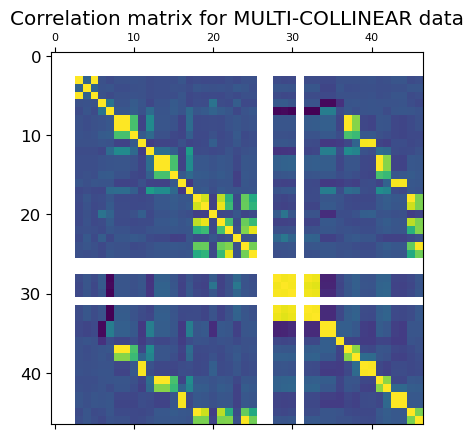

In [17]:
plt.matshow(rfDataOriginal.corr())
plt.title('Correlation matrix for MULTI-COLLINEAR data')
corr = rfDataOriginal.corr()

In [18]:
corr = rfDataOriginal.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.8)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('DayofMonth', 'FlightDate'),
 ('OriginAirportID', 'OriginAirportSeqID'),
 ('OriginAirportID', 'Origin_Point'),
 ('OriginAirportSeqID', 'Origin_Point'),
 ('OriginStateFips', 'Origin_State'),
 ('OriginStateFips', 'OriginState_Name'),
 ('DestAirportID', 'DestAirportSeqID'),
 ('DestAirportID', 'Destination'),
 ('DestAirportSeqID', 'Destination'),
 ('DestStateFips', 'Dest_State'),
 ('DestStateFips', 'Dest_StateName'),
 ('CRSDepTime', 'DepTime'),
 ('CRSDepTime', 'WheelsOff'),
 ('CRSDepTime', 'DepTime_Blk'),
 ('DepTime', 'WheelsOff'),
 ('DepTime', 'DepTime_Blk'),
 ('WheelsOff', 'DepTime_Blk'),
 ('WheelsOn', 'ArrTime'),
 ('CRSArrTime', 'ArrTime_Blk'),
 ('CRSElapsedTime', 'ActualElapsedTime'),
 ('CRSElapsedTime', 'AirTime'),
 ('CRSElapsedTime', 'Distance'),
 ('CRSElapsedTime', 'DistanceGroup'),
 ('ActualElapsedTime', 'AirTime'),
 ('ActualElapsedTime', 'Distance'),
 ('ActualElapsedTime', 'DistanceGroup'),
 ('AirTime', 'Distance'),
 ('AirTime', 'DistanceGroup'),
 ('Distance', 'DistanceGroup'),


In [19]:
rfDataOriginal.drop(['OriginAirportSeqID','OriginCityMarketID', 'OriginStateFips', 'OriginWac', 
                     'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac',
                     'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime','Carrier_Name', 
                     'Origin_Point', 'Origin_CityName', 'Origin_State', 'OriginState_Name', 
                     'Destination', 'Dest_CityName', 'Dest_State', 'Dest_StateName'], axis=1, inplace=True)

In [20]:
print('Dimension finally reduced to:')
print(len(rfDataOriginal.columns))
list(rfDataOriginal.columns)

Dimension finally reduced to:
27


['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'AirlineID',
 'FlightNum',
 'OriginAirportID',
 'DestAirportID',
 'DepTime',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'ArrTime',
 'Cancelled',
 'Diverted',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'DistanceGroup',
 'Unique_Carrier',
 'Tail_Number',
 'DepTime_Blk',
 'ArrTime_Blk']

### Model building with non-redundant variables

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(rfDataOriginal, Delay_YesNo, test_size=0.2, random_state=42)

In [22]:
startTimeGS = datetime.now()
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 25],
    # 'min_samples_split': [2, 4],
    # 'min_samples_leaf': [2, 4],
    # 'max_features': ['sqrt', 'log2'],
    "criterion": ["gini", "entropy"]
}

grid_rf = GridSearchCV(rf, param_grid, cv=10)
grid_rf.fit(X_train, Y_train)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.cv_results_ 
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')


Random forest Grid Search with non-redundant variables took [ 0:06:59.010791 ] seconds.


In [23]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestClassifier(criterion='entropy', n_estimators=25)
{'criterion': 'entropy', 'n_estimators': 25}


{'mean_fit_time': array([ 5.69681895, 13.88343313,  5.6594785 , 14.50022461]),
 'std_fit_time': array([0.40423273, 0.94625445, 0.155024  , 1.0564316 ]),
 'mean_score_time': array([0.05010097, 0.10674164, 0.04350045, 0.102198  ]),
 'std_score_time': array([0.00803027, 0.00946065, 0.00294001, 0.00985808]),
 'param_criterion': masked_array(data=['gini', 'gini', 'entropy', 'entropy'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 25, 10, 25],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'n_estimators': 10},
  {'criterion': 'gini', 'n_estimators': 25},
  {'criterion': 'entropy', 'n_estimators': 10},
  {'criterion': 'entropy', 'n_estimators': 25}],
 'split0_test_score': array([0.89124872, 0.91152764, 0.89924514, 0.9073695 ]),
 'split1_test_score': array([0.897326  , 0.91120778, 0.89073695, 0.91306295]),


In [24]:
startTimeRF = datetime.now()
rf = RandomForestClassifier(n_estimators=bestParameters.get('n_estimators'),
#                            min_samples_split=bestParameters.get('min_samples_split'),
#                           min_samples_leaf=bestParameters.get('min_samples_leaf'),
#                           max_features=bestParameters.get('max_features'),
                           criterion=bestParameters.get('criterion'))

cv = KFold(n_splits=10, shuffle=True, random_state=2)
cvScores = cross_val_score(rf, X_train, Y_train, cv=cv)
print('Mean cross-validation score is: ' + str(np.mean(cvScores)))
rf.fit(X_train, Y_train)
print('Random forest training and testing with non-redundant variables took [',
      datetime.now() - startTimeRF, '] seconds.')

Mean cross-validation score is: 0.9155183283723451
Random forest training and testing with non-redundant variables took [ 0:02:49.748586 ] seconds.


Accuracy: 91.64%
Recall: 89.16%
Confusion matrix:
[[18337  1144]
 [ 2125 17474]]
Area under the ROC curve: 0.08357389199468546


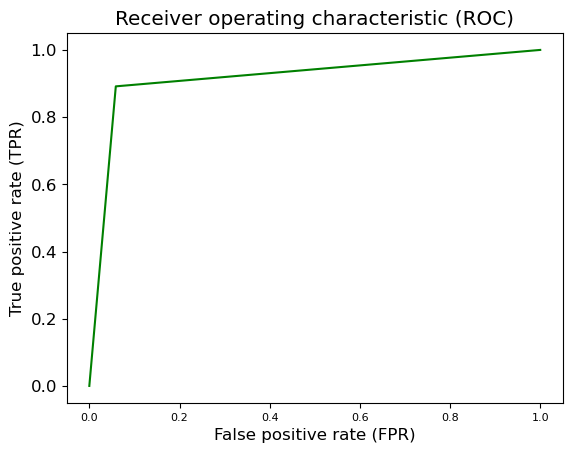

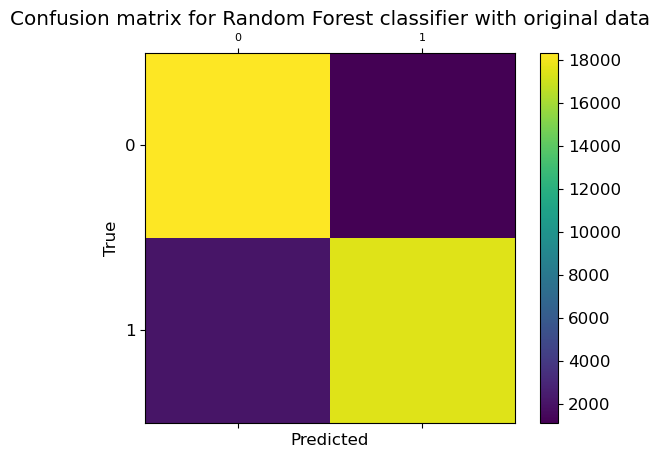

In [25]:
Y_rf_pred = rf.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, Y_rf_pred, labels=labels)

print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
print('Confusion matrix:')
print(cm)

fpr, tpr, _ = roc_curve(Y_test, Y_rf_pred)
auc = np.trapz(fpr, tpr)
print('Area under the ROC curve: ' + str(auc))

fig = plt.figure(1)
plt.plot(fpr, tpr, color='green')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Receiver operating characteristic (ROC)')

fig = plt.figure(2)
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Random Forest classifier with original data')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model creation with PCA components

In [26]:
# Removal of redundant and highly collinear variables from dataset
rfDataPCA = pd.DataFrame(data)
rfDataPCA.drop(['OriginAirportSeqID','OriginCityMarketID', 'OriginStateFips', 'OriginWac', 
                     'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac',
                     'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime','Carrier_Name', 
                     'Origin_Point', 'Origin_CityName', 'Origin_State', 'OriginState_Name', 
                     'Destination', 'Dest_CityName', 'Dest_State', 'Dest_StateName'], axis=1, inplace=True)
print('Dimension reduced to:')
print(len(rfDataPCA.columns))
list(rfDataPCA.columns)
rfDataPCA.describe()

Dimension reduced to:
28


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,FlightNum,OriginAirportID,DestAirportID,...,Diverted,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,Unique_Carrier,Tail_Number,DepTime_Blk,ArrTime_Blk
count,195398.0,195398.0,195398.0,195398.000000,195398.000000,1.953980e+05,195398.000000,195398.000000,195398.000000,195398.000000,...,195398.0,195398.000000,195398.000000,195398.0,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000
mean,2017.0,1.0,1.0,14.908019,3.888279,2.017011e+07,19916.178722,2052.984749,12741.414339,12775.120866,...,0.0,151.548470,124.365439,1.0,892.067421,4.033163,5.919687,2268.751277,8.347051,10.153006
std,0.0,0.0,0.0,8.893236,2.077276,8.893236e+00,388.719304,1770.954609,1523.936548,1523.409660,...,0.0,81.881579,79.344836,0.0,645.994850,2.517332,4.030049,1279.525163,4.707543,4.843658
min,2017.0,1.0,1.0,1.000000,1.000000,2.017010e+07,19393.000000,1.000000,10135.000000,10135.000000,...,0.0,16.000000,7.000000,1.0,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.0,1.0,1.0,6.000000,2.000000,2.017011e+07,19790.000000,591.000000,11292.000000,11292.000000,...,0.0,91.000000,65.000000,1.0,404.000000,2.000000,3.000000,1189.000000,4.000000,6.000000
50%,2017.0,1.0,1.0,15.000000,4.000000,2.017012e+07,19805.000000,1525.000000,12892.000000,12892.000000,...,0.0,132.000000,105.000000,1.0,731.000000,3.000000,7.000000,2293.000000,8.000000,11.000000
75%,2017.0,1.0,1.0,22.000000,6.000000,2.017012e+07,20304.000000,3113.000000,14057.000000,14100.000000,...,0.0,186.000000,156.000000,1.0,1139.000000,5.000000,9.000000,3405.000000,12.000000,14.000000
max,2017.0,1.0,1.0,31.000000,7.000000,2.017013e+07,21171.000000,7439.000000,16218.000000,16218.000000,...,0.0,734.000000,704.000000,1.0,4983.000000,11.000000,11.000000,4359.000000,18.000000,18.000000


In [27]:
indices = np.where(corr > 0.7)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('DayofMonth', 'FlightDate'),
 ('OriginAirportID', 'OriginAirportSeqID'),
 ('OriginAirportID', 'Origin_Point'),
 ('OriginAirportID', 'Origin_CityName'),
 ('OriginAirportSeqID', 'Origin_Point'),
 ('OriginAirportSeqID', 'Origin_CityName'),
 ('OriginStateFips', 'Origin_State'),
 ('OriginStateFips', 'OriginState_Name'),
 ('DestAirportID', 'DestAirportSeqID'),
 ('DestAirportID', 'Destination'),
 ('DestAirportID', 'Dest_CityName'),
 ('DestAirportSeqID', 'Destination'),
 ('DestAirportSeqID', 'Dest_CityName'),
 ('DestStateFips', 'Dest_State'),
 ('DestStateFips', 'Dest_StateName'),
 ('CRSDepTime', 'DepTime'),
 ('CRSDepTime', 'WheelsOff'),
 ('CRSDepTime', 'DepTime_Blk'),
 ('CRSDepTime', 'ArrTime_Blk'),
 ('DepTime', 'WheelsOff'),
 ('DepTime', 'DepTime_Blk'),
 ('DepTime', 'ArrTime_Blk'),
 ('WheelsOff', 'DepTime_Blk'),
 ('WheelsOff', 'ArrTime_Blk'),
 ('WheelsOn', 'CRSArrTime'),
 ('WheelsOn', 'ArrTime'),
 ('WheelsOn', 'ArrTime_Blk'),
 ('CRSArrTime', 'ArrTime'),
 ('CRSArrTime', 'ArrTime_Blk'),
 ('Ar

In [28]:
rfDataPCA.drop(['FlightDate','DepTime','DepTime_Blk','ActualElapsedTime','AirTime','DistanceGroup','DepTime_Blk'], 
          axis=1, inplace=True)

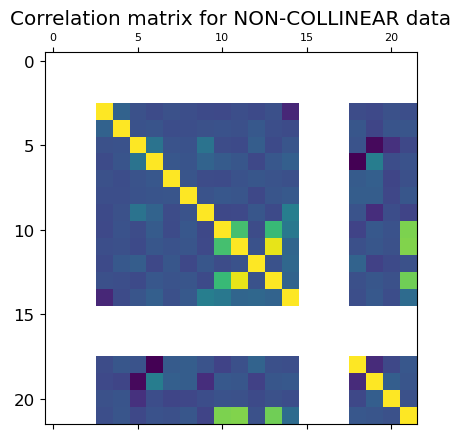

In [29]:
#Check for collinearity
plt.matshow(rfDataPCA.corr())
plt.title('Correlation matrix for NON-COLLINEAR data')
corr = rfDataPCA.corr()

In [30]:
indices = np.where(corr > 0.7)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('WheelsOff', 'ArrTime_Blk'),
 ('WheelsOn', 'ArrTime'),
 ('WheelsOn', 'ArrTime_Blk'),
 ('ArrTime', 'ArrTime_Blk')]

In [31]:
print('Dimension reduced to:')
print(len(rfDataPCA.columns))
rfDataPCA.describe()

Dimension reduced to:
22


,Year,Quarter,Month,DayofMonth,DayOfWeek,AirlineID,FlightNum,OriginAirportID,DestAirportID,TaxiOut,...,TaxiIn,ArrTime,ArrDel15,Cancelled,Diverted,Flights,Distance,Unique_Carrier,Tail_Number,ArrTime_Blk
count,195398.0,195398.0,195398.0,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,195398.000000,...,195398.000000,195398.000000,195398.000000,195398.0,195398.0,195398.0,195398.000000,195398.000000,195398.000000,195398.000000
mean,2017.0,1.0,1.0,14.908019,3.888279,19916.178722,2052.984749,12741.414339,12775.120866,18.921238,...,8.261794,1511.622535,0.500000,0.0,0.0,1.0,892.067421,5.919687,2268.751277,10.153006
std,0.0,0.0,0.0,8.893236,2.077276,388.719304,1770.954609,1523.936548,1523.409660,12.440744,...,8.169938,552.968047,0.500001,0.0,0.0,0.0,645.994850,4.030049,1279.525163,4.843658
min,2017.0,1.0,1.0,1.000000,1.000000,19393.000000,1.000000,10135.000000,10135.000000,1.000000,...,1.000000,1.000000,0.000000,0.0,0.0,1.0,31.000000,0.000000,0.000000,0.000000
25%,2017.0,1.0,1.0,6.000000,2.000000,19790.000000,591.000000,11292.000000,11292.000000,11.000000,...,5.000000,1131.000000,0.000000,0.0,0.0,1.0,404.000000,3.000000,1189.000000,6.000000
50%,2017.0,1.0,1.0,15.000000,4.000000,19805.000000,1525.000000,12892.000000,12892.000000,15.000000,...,6.000000,1555.000000,0.500000,0.0,0.0,1.0,731.000000,7.000000,2293.000000,11.000000
75%,2017.0,1.0,1.0,22.000000,6.000000,20304.000000,3113.000000,14057.000000,14100.000000,22.000000,...,9.000000,1947.000000,1.000000,0.0,0.0,1.0,1139.000000,9.000000,3405.000000,14.000000
max,2017.0,1.0,1.0,31.000000,7.000000,21171.000000,7439.000000,16218.000000,16218.000000,176.000000,...,413.000000,2400.000000,1.000000,0.0,0.0,1.0,4983.000000,11.000000,4359.000000,18.000000


## Dimension reduction with PCA

In [32]:
#PCA 1: On HIGHLY MULTI-COLLINEAR data
pca = PCA(n_components=8)
data_reduced = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[5.10556303e-01 4.89250221e-01 6.90031938e-05 3.51944839e-05
 2.58349909e-05 2.29099767e-05 2.05778396e-05 8.19487210e-06]


array([ 51.06,  99.99, 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ])

Text(0, 0.5, 'Explained variance')

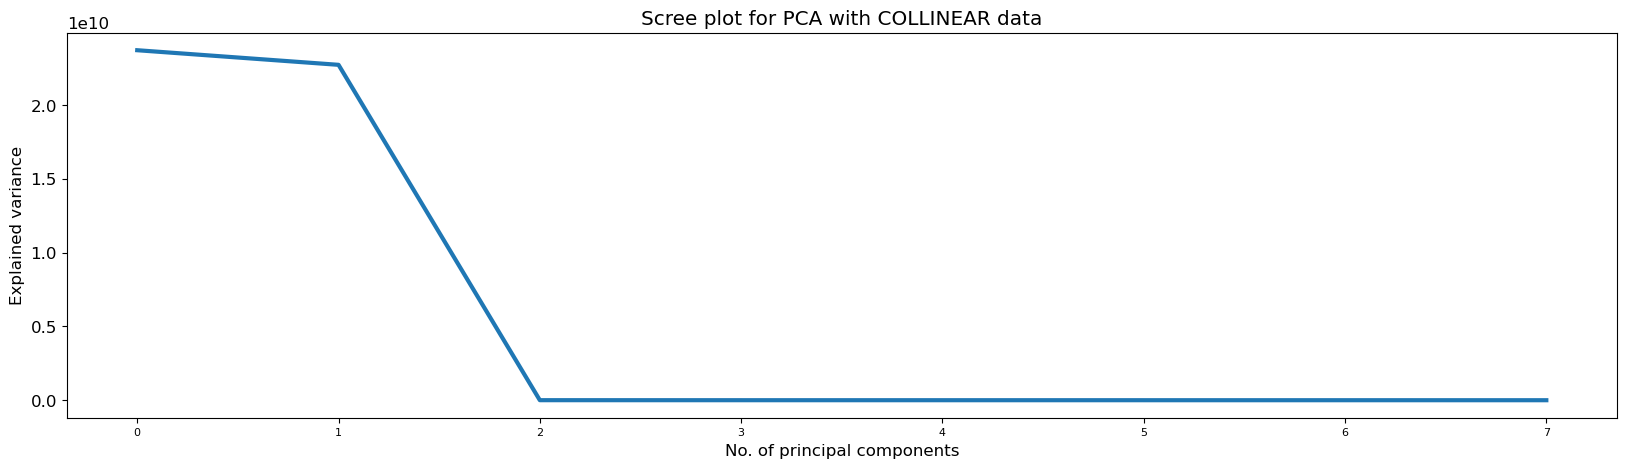

In [33]:
plt.figure(1, figsize=(20, 5))
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.title('Scree plot for PCA with COLLINEAR data')
plt.xlabel('No. of principal components')
plt.ylabel('Explained variance')

In [34]:
#PCA 2: On PARTIALLY MULTI-COLLINEAR data
pca = PCA(n_components=8)
rfDataOriginal_reduced = pca.fit_transform(rfDataOriginal)
print(pca.explained_variance_ratio_)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[0.28867191 0.21552975 0.20468975 0.14543766 0.07701806 0.03364675
 0.01994904 0.01275127]


array([28.87, 50.42, 70.89, 85.43, 93.13, 96.49, 98.48, 99.76])

Text(0, 0.5, 'Explained variance')

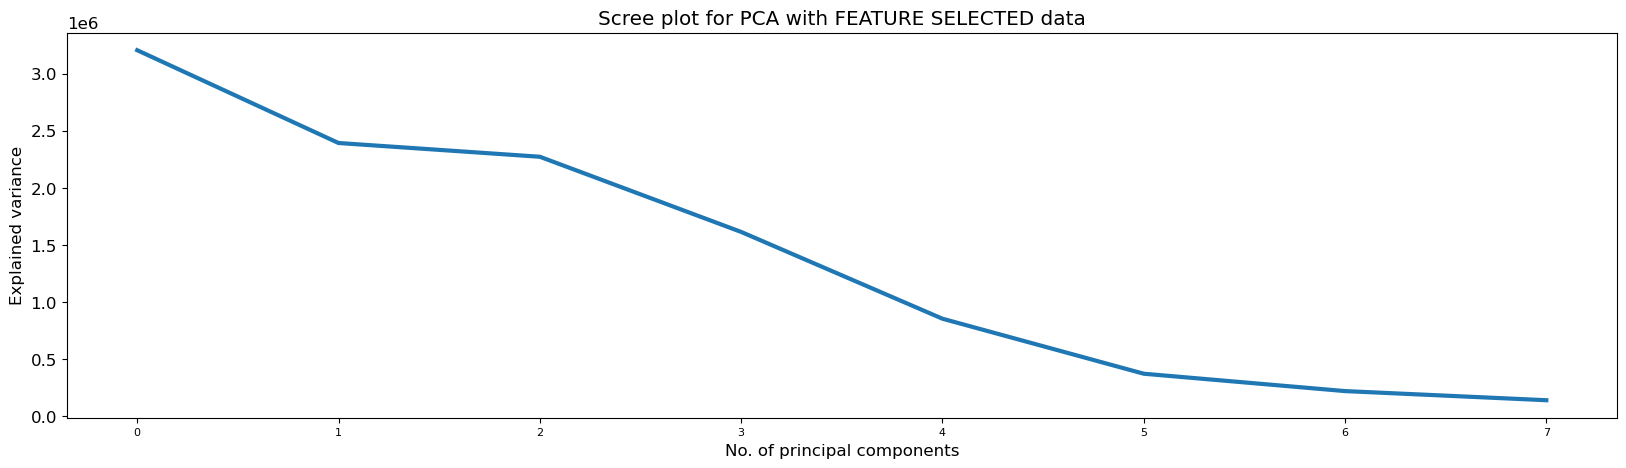

In [35]:
plt.figure(1, figsize=(20, 5))
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.title('Scree plot for PCA with FEATURE SELECTED data')
plt.xlabel('No. of principal components')
plt.ylabel('Explained variance')

In [36]:
#PCA 3: On LOW MULTI-COLLINEAR data
pca = PCA(n_components=8)
rfDataPCA_reduced = pca.fit_transform(rfDataPCA)
print(pca.explained_variance_ratio_)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[0.29547713 0.2207447  0.20959372 0.14896352 0.06480816 0.03346826
 0.01308335 0.01252685]


array([29.55, 51.62, 72.58, 87.48, 93.96, 97.31, 98.62, 99.87])

Text(0, 0.5, 'Explained variance')

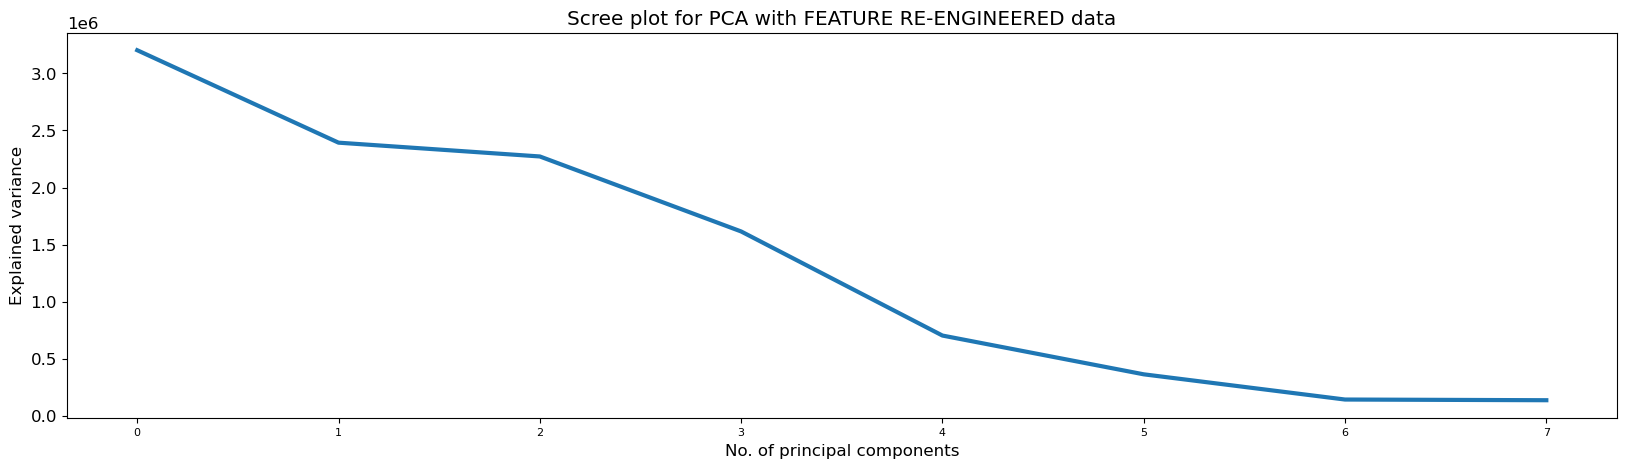

In [37]:
plt.figure(1, figsize=(20, 5))
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.title('Scree plot for PCA with FEATURE RE-ENGINEERED data')
plt.xlabel('No. of principal components')
plt.ylabel('Explained variance')

In [38]:
Delay_YesNo = data['ArrDel15']
data.drop(['ArrDel15'], axis=1, inplace=True)#Removing target variable
print('Dimension reduced to:')
print(len(data.columns))
data.describe()
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
print('Cumulative explained variance:')
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

Dimension reduced to:
47
[0.5105563  0.48925022]
Cumulative explained variance:


array([51.06, 99.99])

# Model building with dimension reduced data

In [39]:
x_train, x_test, y_train, y_test = train_test_split(data, Delay_YesNo, test_size=0.2, random_state=42)

In [40]:
startTimeGS = datetime.now()
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 25],
    # 'min_samples_split': [2, 4],
    # 'min_samples_leaf': [2, 4],
    # 'max_features': ['sqrt', 'log2'],
    "criterion": ["gini", "entropy"]
}

grid_rf = GridSearchCV(rf, param_grid, cv=10)
grid_rf.fit(x_train, y_train)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.cv_results_  # Use cv_results_ instead of grid_scores_
print('Random forest Grid Search with dimension reduced data took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with dimension reduced data took [ 0:08:02.839777 ] seconds.


In [41]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestClassifier(criterion='entropy', n_estimators=25)
{'criterion': 'entropy', 'n_estimators': 25}


{'mean_fit_time': array([ 6.39314873, 16.56656508,  7.0979315 , 16.06800191]),
 'std_fit_time': array([0.26840401, 0.72103435, 0.43694037, 0.33235624]),
 'mean_score_time': array([0.05072536, 0.11592321, 0.0517401 , 0.10446026]),
 'std_score_time': array([0.00292531, 0.01407275, 0.00289495, 0.00489951]),
 'param_criterion': masked_array(data=['gini', 'gini', 'entropy', 'entropy'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 25, 10, 25],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'n_estimators': 10},
  {'criterion': 'gini', 'n_estimators': 25},
  {'criterion': 'entropy', 'n_estimators': 10},
  {'criterion': 'entropy', 'n_estimators': 25}],
 'split0_test_score': array([0.90768936, 0.92963153, 0.91056807, 0.92470573]),
 'split1_test_score': array([0.90980041, 0.93084698, 0.90992835, 0.93046315]),


In [42]:
startTimeRF = datetime.now()
rf = RandomForestClassifier(n_estimators=bestParameters.get('n_estimators'),
#                            min_samples_split=bestParameters.get('min_samples_split'),
#                            min_samples_leaf=bestParameters.get('min_samples_leaf'),
#                            max_features=bestParameters.get('max_features'),
                            criterion=bestParameters.get('criterion'))

cv = KFold(n_splits=10, shuffle=True, random_state=2)
cvScores = cross_val_score(rf, x_train, y_train, cv=cv)
print('Mean cross-validation score is: ' + str(np.mean(cvScores)))
rf.fit(x_train, y_train)
print('Random forest training and testing with PCs took [', datetime.now() - startTimeRF, '] seconds.')


Mean cross-validation score is: 0.9306029583923294
Random forest training and testing with PCs took [ 0:03:00.292004 ] seconds.


Accuracy: 93.48%
Recall: 91.98%
Confusion matrix:
[[18505   976]
 [ 1572 18027]]
Area under the ROC curve: 0.06515413570867518


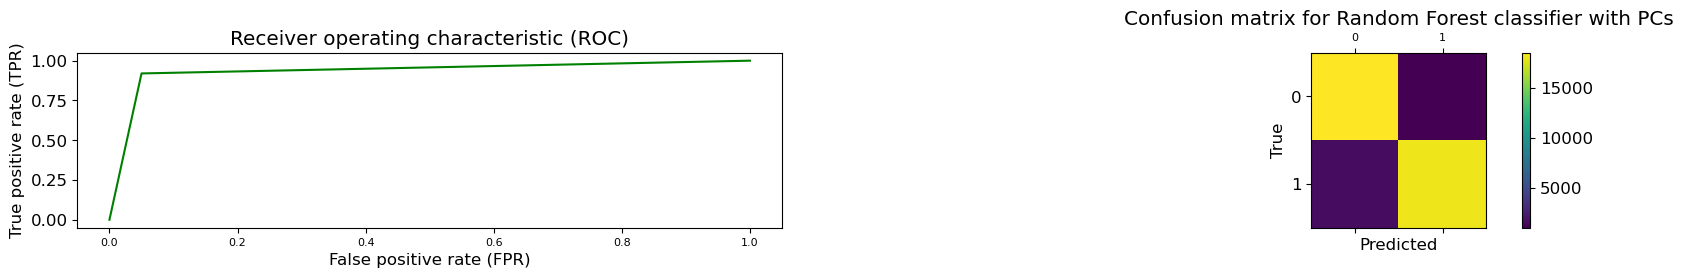

In [43]:
y_rf_pred = rf.predict(x_test)

labels = [0, 1]
cm = confusion_matrix(y_test, y_rf_pred, labels=labels)

print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
print('Confusion matrix:')
print(cm)

fpr, tpr, _ = roc_curve(y_test, y_rf_pred)
auc = np.trapz(fpr,tpr)
print('Area under the ROC curve: ' + str(auc))

fig = plt.figure(figsize=(20, 5))

plt.subplot2grid((2, 2), (1, 0), colspan=1)
#plt.subplot(1,2,1)
plt.plot(fpr,tpr,color='green')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Receiver operating characteristic (ROC)')

ax1 = plt.subplot2grid((2, 2), (1, 1))
#ax = fig.add_subplot(122)
cax = ax1.matshow(cm)
plt.title('Confusion matrix for Random Forest classifier with PCs')
fig.colorbar(cax)
ax1.set_xticklabels([''] + labels)
ax1.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [44]:
print('Overall execution took [', datetime.now() - startTime, '] seconds.')

Overall execution took [ 0:21:12.115484 ] seconds.


In [45]:
import pickle

# Train the Random Forest model
rf.fit(x_train, y_train)

# Save the trained model to a file using pickle
model_filename = 'random_forest_model.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(rf, model_file)




In [46]:
# import pickle

# # Save the db object to a pickle file
# with open('C:/Users/sulayako/datamodels/Airline-delay-prediction-in-Python-master/model.pkl', 'wb') as file:
#     pickle.dump(rf, file)

# # Confirm that the file is saved
# print("DB object saved to db.pkl")


In [47]:
# import pickle

# # Assuming "bestModel" is your trained Random Forest model
# model_filename = 'random_forest_model.pkl'

# # Save the model to a file
# with open(model_filename, 'wb') as model_file:
#     pickle.dump(bestModel, model_file)

# print(f"Model saved to {model_filename}")
